# Text similarity TASK 1

In [1]:
import pandas as pd
import hashlib
import os # currentpath (not used)
import glob # find directory
import numpy as np 
import re

Load data_set
To read the dataset we use the pandas library:import pandas as pd

We  use Dataset For Exploring Climate Change Narratives On Television News 2009-2020, from https://blog.gdeltproject.org/a-new-dataset-for-exploring-climate-change-narratives-on-television-news-2009-2020/

Sort and Data (we are intetsted in the Snippet column in each file) 

In [2]:
# Get CSV files list from a folder
#print (glob.glob("*/"))
csv_files = glob.glob("*/*.csv")
#print(csv_files)
# Read each CSV file into DataFrame
# This creates a list of dataframes
#files_list = (pd.read_csv(file) for file in csv_files)
#file_data = pd.read_csv(csv_files[0], delimiter=",")
#file_data.head()
counter = 0
df_files = []
output_directory = os.path.join(os.getcwd(), "Data_txt")

# Check if the output directory exists, create it if not
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for counter, csv_file in enumerate(csv_files):
    df_files = pd.read_csv(csv_file, usecols=['Snippet'])
    file_name_new = 'TextFile_{}.txt'.format(counter)
    file_new = os.path.join(output_directory, file_name_new)

    with open(file_new, "w+",encoding='utf-8') as file:
        df_files['Snippet'] = df_files['Snippet']
        df_string = df_files.to_string(header=False, index=False)
        file.write(df_string)

    # Reopen the file for reading and cleaning
    with open(file_new, "r",encoding='utf-8') as input_file:
        content = input_file.read()

    # Clean the content (remove multiple white spaces) and newline characters,use lowercase
    #cleaned_content = re.sub("( )+|(\n)+"," ",content).lower()
    cleaned_content = ' '.join(content.split())

    # Reopen the file for writing the cleaned content
    with open(file_new, "w",encoding='utf-8') as output_file:
        output_file.write(cleaned_content)

# Shingler Class:
A class Shingling that constructs k–shingles of a given length k (e.g., 10) from a given document, computes a hash value for each unique shingle and represents the document in the form of an ordered set of its hashed k-shingles.

The __init__ method to initialize the values of shingle_size and text_file. 
The _generate_shingles method within the class takes the text_file as input and returns a set of shingles.

In [3]:
class Shingler:
    def __init__(self, text_file, shingle_size):
        self.shingle_size = shingle_size
        self.text_file = text_file

    def _generate_shingles(self):
        shingles = set()
        document_length = len(self.text_file)

        for i in range(document_length - self.shingle_size + 1):
            shingle = self.text_file[i:i + self.shingle_size]
            shingles.add(hash(shingle))

        return sorted(list(shingles))
     

In [4]:
# Example usage:
shingle_size_value = 5

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

# Open the file and read its content
with open(files_txt_path[0], 'r') as file:
    text_file_content = file.read()

    # Create an instance of the Shingler class
    shingler_instance = Shingler(text_file_content, shingle_size_value)

    # Generate and print the shingles
    result = shingler_instance._generate_shingles()
    #print(result)

# CompareSet Class:
A class CompareSets computes the Jaccard similarity of two sets of integers – two sets of hashed shingles.

The Jaccard similarity between two sets A and B is the size of their intersection divided by the size of their union.

In [5]:
class CompareSets:
    def __init__(self, set1, set2):
        self.set1 = set(set1)
        self.set2 = set(set2)

    def jaccard_similarity(self):
        intersection_size = len(self.set1.intersection(self.set2))
        union_size = len(self.set1.union(self.set2))

        if union_size == 0:
            return 0.0  # Handle the case when both sets are empty
        else:
            return intersection_size / union_size


In [6]:
# Example usage:

shingle_size_value = 5

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

# Open the file and read its content
with open(files_txt_path[0], 'r', encoding='utf-8') as file:
    text_file_content_1 = file.read()

# Open the file and read its content
with open(files_txt_path[1], 'r', encoding='utf-8') as file:
    text_file_content_2 = file.read()

# Create instances of the Shingler class
shingler_instance_1 = Shingler(text_file_content_1, shingle_size_value)
shingler_instance_2 = Shingler(text_file_content_2, shingle_size_value)

# Generate and print the shingles
hashed_shingles_set_1 = shingler_instance_1._generate_shingles()
hashed_shingles_set_2 = shingler_instance_2._generate_shingles()

# Create an instance of CompareSets for Jaccard Similarity
compare_sets_instance = CompareSets(hashed_shingles_set_1, hashed_shingles_set_2)

# Estimate similarity using Jaccard Similarity
similarity = compare_sets_instance.jaccard_similarity()

print(f"Jaccard Similarity: {similarity}")


Jaccard Similarity: 0.26867931249443405


# Minhash Class: 
A class MinHashing that builds a minHash signature (in the form of a set of hashed shingles) using K random hash functions (sig_size), we’ll get a MinHash signature with K values for each set. 

+ The minash of a set can be seen as  a unique signature with a fixed length (The MinHashing for a set preserves Jaccard similarity (approximate)).

+ Take the first hash function, and apply it to all of the shingle values in a document.

+ Find the minimum hash value produced and use it as the first component of the MinHash signature.
+  take the second hash function, and again find the minimum resulting hash value, and use this as the second component.
+ And so on…

In [7]:
class MinHashing:
    def __init__(self, hashed_shingles, signature_length):
        self.hashed_shingles = hashed_shingles
        self.signature_length = signature_length
        self.coefficients = np.random.randint(1, 100, size=self.signature_length)
        self.bias_terms = np.random.randint(1, 100, size=self.signature_length)
        self.mod_values = np.ones(self.signature_length) * 2**32 - 1

    def hash_value(self, value, index):
        return (self.coefficients[index] * value + self.bias_terms[index]) % self.mod_values[index]

    def compute_minhash_signature(self):
        if not self.hashed_shingles:
            raise ValueError("Input set of hashed shingles cannot be empty")

        signature = []

        for i in range(self.signature_length):
            min_hash_value = float('inf')
            for hashed_shingle in self.hashed_shingles:
                hash_result = self.hash_value(hashed_shingle, i)
                min_hash_value = min(min_hash_value, hash_result)

            signature.append(min_hash_value)

        return signature

In [8]:
# Example usage:
shingle_size_value = 5

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

# Open the file and read its content
with open(files_txt_path[0], 'r', encoding='utf-8') as file:
    text_file_content = file.read()

    # Create an instance of the Shingler class
    shingler_instance = Shingler(text_file_content, shingle_size_value)

    # Generate and print the shingles
    hashed_shingles_set = shingler_instance._generate_shingles()
       
    signature_length = 100
    
    # Create a MinHashing instance
minhashing_instance = MinHashing(hashed_shingles_set, signature_length)

# Compute MinHash signature for the set of hashed shingles
minhash_signature = minhashing_instance.compute_minhash_signature()

# Print the MinHash signature
print("MinHash Signature:", minhash_signature, len(minhash_signature))

MinHash Signature: [565469.0, 607811.0, 31198.0, 141913.0, 433830.0, 333608.0, 607811.0, 265340.0, 147030.0, 505806.0, 66335.0, 531164.0, 47309.0, 125842.0, 60773.0, 173826.0, 182005.0, 456038.0, 41923.0, 32212.0, 304468.0, 64424.0, 433830.0, 412441.0, 41818.0, 265139.0, 76211.0, 47309.0, 3767.0, 174048.0, 265139.0, 70700.0, 49091.0, 65413.0, 321966.0, 604299.0, 331291.0, 88231.0, 32468.0, 73515.0, 121562.0, 50103.0, 128848.0, 182005.0, 91003.0, 412441.0, 243124.0, 88231.0, 434432.0, 433830.0, 132791.0, 220822.0, 24540.0, 654403.0, 174048.0, 256608.0, 96892.0, 65349.0, 208941.0, 106355.0, 654403.0, 54035.0, 76211.0, 521477.0, 313283.0, 189252.0, 74643.0, 608835.0, 101109.0, 607811.0, 364523.0, 30387.0, 521477.0, 47309.0, 149943.0, 32212.0, 32720.0, 664083.0, 233533.0, 65413.0, 64424.0, 248468.0, 153446.0, 662583.0, 182005.0, 654403.0, 104470.0, 152422.0, 73515.0, 30387.0, 32212.0, 456038.0, 165646.0, 128848.0, 15855.0, 142425.0, 505806.0, 662583.0, 265340.0, 377913.0] 100


# Jaccard Similarity Estimation:

The key insight of MinHash is that the probability that the minimum hash value for a set accurately represents its intersection with another set is equal to the Jaccard similarity of the sets.
Implementation Steps:

To estimate the Jaccard similarity between two sets, compare their MinHash signatures.
The fraction of hash functions for which the signatures match gives an estimate of the Jaccard similarity.

In [8]:
class CompareSignatures:
    def __init__(self, signatures_set_doc1, signatures_set_doc2, no_hash_functions):
        self.signatures_set_doc1 = set(signatures_set_doc1)
        self.signatures_set_doc2 = set(signatures_set_doc2)
        self.no_hash_functions = no_hash_functions

    def estimate_jaccard_similarity(self):
       
        intersection = len(list(self.signatures_set_doc1.intersection(self.signatures_set_doc2)))
        
        if self.no_hash_functions == 0:
            return 0.0  # Handle the case when no hash functions are used
        
        return float(intersection) / self.no_hash_functions


In [10]:
# Example usage:

shingle_size_value = 5
no_hash_functions = 100

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

# Open the file and read its content
with open(files_txt_path[0], 'r', encoding='utf-8') as file:
    text_file_content_1 = file.read()

# Open the file and read its content
with open(files_txt_path[1], 'r', encoding='utf-8') as file:
    text_file_content_2 = file.read()

# Create instances of the Shingler class
shingler_instance_1 = Shingler(text_file_content_1, shingle_size_value)
shingler_instance_2 = Shingler(text_file_content_2, shingle_size_value)

# Generate and print the shingles
hashed_shingles_set_1 = shingler_instance_1._generate_shingles()
hashed_shingles_set_2 = shingler_instance_2._generate_shingles()

# Create MinHashing instances
minhashing_instance_1 = MinHashing(hashed_shingles_set_1, no_hash_functions)
minhashing_instance_2 = MinHashing(hashed_shingles_set_2, no_hash_functions)

# Compute MinHash signature for the set of hashed shingles
minhash_signature_1 = minhashing_instance_1.compute_minhash_signature()
minhash_signature_2 = minhashing_instance_2.compute_minhash_signature()

# Create an instance of CompareSets for Jaccard Similarity
compare_signatures_instance = CompareSignatures(minhash_signature_1, minhash_signature_2,no_hash_functions)

# Estimate similarity using Jaccard Similarity
similarity_estimate = compare_signatures_instance. estimate_jaccard_similarity()

print(f"Estimated Similarity: {similarity_estimate}")


Estimated Similarity: 0.11


# Evaluation ( Shingles vs. Minhash)
+ Accuracy: we will compare the simalarity values (Hashed Shingles vs. Minhash)
+ The implementation's scalability (the execution time versus the size of the input dataset

In [15]:
import glob
import numpy as np

# Accuracy

shingle_size_value = 5
no_hash_functions = 100
n_files = 20  # Corrected the variable name

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")
# Lists to store results
my_value_Jaccard = np.zeros(n_files)
my_value_minHash = np.zeros(n_files)

# Open the first file and read its content
with open(files_txt_path[0], 'r', encoding='utf-8') as file:
    text_file_content_1 = file.read()
    shingler_instance_1 = Shingler(text_file_content_1, shingle_size_value)
    hashed_shingles_set_1 = shingler_instance_1._generate_shingles()
    minhashing_instance_1 = MinHashing(hashed_shingles_set_1, no_hash_functions)
    minhash_signature_1 = minhashing_instance_1.compute_minhash_signature()

# Open other files and read their content
for indx in range(n_files):
    with open(files_txt_path[indx], 'r', encoding='utf-8') as file:
        text_file_content_2 = file.read()
        shingler_instance_2 = Shingler(text_file_content_2, shingle_size_value)
        hashed_shingles_set_2 = shingler_instance_2._generate_shingles()
        minhashing_instance_2 = MinHashing(hashed_shingles_set_2, no_hash_functions)
        minhash_signature_2 = minhashing_instance_2.compute_minhash_signature()

        compare_sets_instance = CompareSets(hashed_shingles_set_1, hashed_shingles_set_2)
        similarity_Jaccard = compare_sets_instance.jaccard_similarity()
        my_value_Jaccard[indx] = similarity_Jaccard

        compare_signatures_instance = CompareSignatures(minhash_signature_1, minhash_signature_2, no_hash_functions)
        similarity_estimate = compare_signatures_instance.estimate_jaccard_similarity()
        my_value_minHash[indx] = similarity_estimate

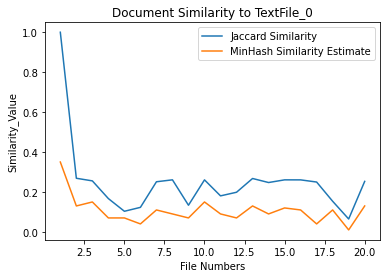

In [16]:
# Accuracy Plot
import matplotlib.pyplot as plt

# Plotting the results
# Set x-values as range from 1 to the list size
ix_d = range(1, len(my_value_Jaccard) + 1)
plt.plot(ix_d, my_value_Jaccard, label='Jaccard Similarity')
plt.plot(ix_d, my_value_minHash, label='MinHash Similarity Estimate')

# Adding labels and title
plt.xlabel('File Numbers')
plt.ylabel('Similarity_Value')
plt.title('Document Similarity to TextFile_0')

# Adding legend
plt.legend()

# Show the plot
plt.show()

Evaluation: Execution time for text similarity check (Shingles vs. Minhash)

In [17]:
def list_shingles(txt_files, shingle_size_k_value):
    # Create a list to store hashed shingles for each document
    shingles_list = []

    # Iterate through each text file
    for txt_file in txt_files:
        # Create a Shingling instance for the document
        shingler_instance = Shingler(txt_file, shingle_size_k_value)

        # Get the ordered set of hashed shingles for the document
        hashed_shingles = shingler_instance._generate_shingles()
        
        # Append the hashed shingles to the list
        shingles_list.append(hashed_shingles)

    return shingles_list

In [18]:
def calculate_jaccard_similarity_shingles(shingles_list):
    # Create the Similarity Matrix, storing the percentage of similarity document by document
    similarity_Jaccard_all = np.zeros((len(shingles_list), len(shingles_list)))

    # Compute the Jaccard Similarity
    for i in range(len(shingles_list)):
        for j in range(len(shingles_list)):
            compare_sets_instance_all = CompareSets(shingles_list[i], shingles_list[j])
            similarity_Jaccard_all[i, j] = compare_sets_instance_all.jaccard_similarity()

    return similarity_Jaccard_all

In [19]:
   def calculate_all_signature(no_hash_functions, shingles_list):
    signatures_all = []

    # For every set of shingles in the list of all shingles
    for shingles in shingles_list:
        # Apply the same hash function to every set of shingles (to every document's shingles)
        minhashing_instance = MinHashing(shingles, no_hash_functions)
        minhash_signature = minhashing_instance.compute_minhash_signature()

        # Minimum hash value for a set at its index inside the list
        signatures_all.append(minhash_signature)

    return signatures_all
     

In [20]:
import numpy as np

def estimate_jaccard_similarity(signatures_all, no_hash_functions, shingles_list):
    # Create the Similarity Matrix, storing the percentage of similarity document by document
    estimate_similarity_Jaccard_all = np.zeros((len(shingles_list), len(shingles_list)))
    
    # Compute the Jaccard Similarity
    for i in range(len(shingles_list)):
        for j in range(len(shingles_list)):
            compare_signatures_instance = CompareSignatures(signatures_all[i], signatures_all[j], no_hash_functions)
            estimate_similarity_Jaccard_all[i, j] = compare_signatures_instance.estimate_jaccard_similarity()

    return estimate_similarity_Jaccard_all


In [ ]:
import glob
no_hash_functions = 100
shingle_size_value = 5
files_txt_path = glob.glob("*/*.txt")
l_file = files_txt_path[:2]
print(l_file)

all_shingles = list_shingles(l_file, shingle_size_value)

#print (all_shingles[0])

signatures = calculate_all_signature(no_hash_functions,all_shingles)

print(signatures[0])
print (len(signatures[0]))

 Evaluating the execution time for Jaccard similarity computation with different numbers of documents

In [48]:
def count_items(matrix, threshold):
    count = 0
    j=1
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i != j and matrix[i][j] > threshold:
                count += 1
    return count

In [61]:
# Evaluating the execution time for Jaccard similarity computation with different numbers of documents
import time
import glob
import numpy as np  # Don't forget to import numpy

shingle_size_value = 10
no_hash_functions = 100

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

n_files = [5, 10, 15, 30, 35, 40, 45, 50, 55]
t_shin_jacc_sim = []

# Vary the number of documents
for n_file in range(len(n_files)):
    # start timer
    t_start = time.time()
    file_no = n_files[n_file]
    
    l_file = files_txt_path[:file_no]
    all_shingles = list_shingles(l_file, shingle_size_value)
    #print(len(all_shingles))  
    # Compute the Jaccard Similarity
    simil_shingles = calculate_jaccard_similarity_shingles(all_shingles, shingle_size_value)
    #print(len(simil_shingles))   
    t_stop = time.time() - t_start
    t_shin_jacc_sim.append(t_stop)
    
    count= 0
    for i in range(len(simil_shingles)):
        for j in range(len(simil_shingles)):
            if i != j and simil_shingles[i][j] > 0.5:
                count += 1
    
    #count = count_items(simil_shingles, 0.5)
                  
    print("---\nNumber of documents: ", len(all_shingles),"---\nNumber of similar Pair Documents: ", (count)/2, "\nTime spent: ", t_stop)
    
    #print(simil_shingles)

---
Number of documents:  5 ---
Number of similar Pair Documents:  3.0 
Time spent:  0.0
---
Number of documents:  10 ---
Number of similar Pair Documents:  8.0 
Time spent:  0.0
---
Number of documents:  15 ---
Number of similar Pair Documents:  12.0 
Time spent:  0.008271217346191406
---
Number of documents:  30 ---
Number of similar Pair Documents:  26.0 
Time spent:  0.012866735458374023
---
Number of documents:  35 ---
Number of similar Pair Documents:  30.0 
Time spent:  0.032402753829956055
---
Number of documents:  40 ---
Number of similar Pair Documents:  35.0 
Time spent:  0.01592874526977539
---
Number of documents:  45 ---
Number of similar Pair Documents:  40.0 
Time spent:  0.016364336013793945
---
Number of documents:  50 ---
Number of similar Pair Documents:  44.0 
Time spent:  0.007999420166015625
---
Number of documents:  55 ---
Number of similar Pair Documents:  49.0 
Time spent:  0.0


 Evaluating the execution time for estimating similarity computation using Minhash with different numbers of documents

In [62]:
import time
import glob
import numpy as np

shingle_size_value = 10
no_hash_functions = 100

# Get a list of all .txt files in subdirectories
files_txt_path = glob.glob("*/*.txt")

n_files = [5, 10, 15, 30, 35, 40, 45, 50, 55]
t_shin_jacc_sim = []

# Vary the number of documents
for n_file in range(len(n_files)):
    # start timer
    t_start = time.time()
    file_no = n_files[n_file]
    
    l_file = files_txt_path[:file_no]
    all_shingles = list_shingles(l_file, shingle_size_value)
    
    signature_all = calculate_all_signature(no_hash_functions, all_shingles)
    # Estimate the Jaccard Similarity
    
    simil_minHash = estimate_jaccard_similarity(signature_all, no_hash_functions, all_shingles)
    
        
    t_stop = time.time() - t_start
    t_shin_jacc_sim.append(t_stop)

    count= 0
    for i in range(len(simil_minHash)):
        for j in range(len(simil_minHash)):
            if i != j and simil_minHash[i][j] > 0.25:
                count += 1
    
    print("---\nNumber of documents: ", len(all_shingles),"---\nNumber of similar Pair Documents: ", (count)/2, "\nTime spent: ", t_stop)


---
Number of documents:  5 ---
Number of similar Pair Documents:  0.0 
Time spent:  0.08754634857177734
---
Number of documents:  10 ---
Number of similar Pair Documents:  3.0 
Time spent:  0.09569859504699707
---
Number of documents:  15 ---
Number of similar Pair Documents:  7.0 
Time spent:  0.13392996788024902
---
Number of documents:  30 ---
Number of similar Pair Documents:  17.0 
Time spent:  0.30896663665771484
---
Number of documents:  35 ---
Number of similar Pair Documents:  41.0 
Time spent:  0.37435030937194824
---
Number of documents:  40 ---
Number of similar Pair Documents:  28.0 
Time spent:  0.39139223098754883
---
Number of documents:  45 ---
Number of similar Pair Documents:  84.0 
Time spent:  0.4301576614379883
---
Number of documents:  50 ---
Number of similar Pair Documents:  94.0 
Time spent:  0.5080947875976562
---
Number of documents:  55 ---
Number of similar Pair Documents:  97.0 
Time spent:  0.5429103374481201
